# Imports

In [1]:
import pandas as pd
import numpy  as np
import math

import matplotlib.pyplot   as     plt
import seaborn             as     sns
from   matplotlib.gridspec import GridSpec

import inflection
import datetime

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
# FLAGS
CONFIG = {}

CONFIG["SEED"] = 42

# Data Load

In [3]:
df_raw = pd.read_csv("src/datasets/train.csv", low_memory=False)
df_store = pd.read_csv("src/datasets/store.csv", low_memory=False)

In [4]:
# adopting snake_case naming pattern
df_raw.columns   = df_raw.columns.map(lambda x: inflection.underscore(x))
df_store.columns = df_store.columns.map(lambda x: inflection.underscore(x))

In [5]:
# merging dfs
df_full = df_raw.merge(df_store)

# Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(columns="sales"), 
    df_full["sales"], 
    test_size    = 0.25, 
    random_state = CONFIG["SEED"]
)

# creating main dfs
df_train = pd.concat([X_train,y_train], axis=1).rename(columns={0:"sales"})
df_test  = pd.concat([X_test,y_test], axis=1).rename(columns={0:"sales"})

# shapes
df_train.shape, df_test.shape

((762906, 18), (254303, 18))

# Preprocessing

In [7]:
# casting date to datetime
def cast_to_datetime(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    if type(columns) != list:
        columns = [columns]
    for i in columns:
        if i not in df.columns:
            raise ValueError(f"'{i}' is not a column of the passed dataframe")
    for col in columns:
        df[col] = df[col].astype('datetime64[ns]')
    return df

In [8]:
df_train.isna().sum()

store                                0
day_of_week                          0
date                                 0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              1976
competition_open_since_month    242346
competition_open_since_year     242346
promo2                               0
promo2_since_week               381075
promo2_since_year               381075
promo_interval                  381075
sales                                0
dtype: int64

In [9]:
df_train.dtypes

store                             int64
day_of_week                       int64
date                             object
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
sales                             int64
dtype: object

# Feature Engineering

In [54]:
def fillna(df):
    df = df.copy()
    # competition_distance: stores with this field null will get a very high distance, meaning the store is so distant that may not interfere in the competition 
    #--- 200k is roughly 3 times the highest competition distance found in the training set
    df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
    
    #--- for all fields in the format {something}_since_{someday}: fillna with the info derived from the field 'date'
    # competition_open_since ...
    df.loc[df['competition_open_since_month'].isna(), 'competition_open_since_month'] = df.loc[df['competition_open_since_month'].isna()].apply(lambda x: x['date'].month, axis=1)
    df.loc[df['competition_open_since_year'].isna(), 'competition_open_since_year']   = df.loc[df['competition_open_since_year'].isna()].apply(lambda x: x['date'].year, axis=1)
    # df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1).astype(int) 
    # df['competition_open_since_year']  = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1).astype(int)
    
    # promo2_since ...
    df.loc[df['promo2_since_week'].isna(), 'promo2_since_week'] = df.loc[df['promo2_since_week'].isna()].apply(lambda x: x['date'].week, axis=1)
    df.loc[df['promo2_since_year'].isna(), 'promo2_since_year'] = df.loc[df['promo2_since_year'].isna()].apply(lambda x: x['date'].year, axis=1)
    # df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1).astype(int)
    # df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1).astype(int)

    # promo_interval: if it's empty its because there was no promotion window in that store; it'll be set to zero
    df['promo_interval'].fillna(0, inplace=True )

    return df
    
def feature_engineering(df):
    df = df.copy()
    #promo_interval              
    month_map       = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['month'] = df['date'].dt.month
    df['month_map'] = df['date'].dt.month.map(month_map)
    df['is_promo']  = df[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in str(x['promo_interval']), axis=1)
    
    # year
    df['year'] = df['date'].dt.year

    # day of week
    df['cos_day_of_week'] = np.cos(df['day_of_week'] * (math.tau/7)) 
    df['sin_day_of_week'] = np.sin(df['day_of_week'] * (math.tau/7))

    # month
    df['cos_month'] = np.cos(df['date'].dt.month * (math.tau/12)) 
    df['sin_month'] = np.sin(df['date'].dt.month * (math.tau/12)) 

    # day
    df['day']     = df['date'].dt.day
    df['cos_day'] = np.cos(df['date'].dt.day * (math.tau/30)) 
    df['sin_day'] = np.sin(df['date'].dt.day * (math.tau/30))

    # week of year
    df['cos_week_of_year'] = np.cos(df['date'].dt.isocalendar().week * (math.tau/52))
    df['sin_week_of_year'] = np.sin(df['date'].dt.isocalendar().week * (math.tau/52)) 

    # year week
    df['year_week'] = df['date'].dt.strftime('%Y-%W')

    # competition since
    df['competition_since']      = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
    df['competition_time_month'] = ((df['date'] - df['competition_since']) / 30).apply(lambda x: x.days).astype(int)

    # promo since
    df['promo_since']     = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
    df['promo_since']     = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    df['promo_time_week'] = ((df['date'] - df['promo_since']) / 7).apply(lambda x: x.days).astype(int)

    # assortment
    df['assortment'] = df['assortment'].map({"a":"basic", "b":"extra", "c":"extended"})
    
    # state holiday
    df['state_holiday'] = df['state_holiday'].map({"a": "public_holiday", "b": "easter_holiday", "c": "christmas", "0": "regular_day"})
    
    return df

def adjust_data_types(df):
    df = df.copy()
    cols_to_int = [
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2_since_week',
        'promo2_since_year',
        'competition_distance',
        'open',
        'promo',
        'school_holiday',
        'promo2'
    ]

    df[cols_to_int] = df[cols_to_int].astype(int)

    return df

def data_prep(df):
    df = df.copy()
    df = cast_to_datetime(df, ['date'])
    df = fillna(df)
    df = adjust_data_types(df)
    df = feature_engineering(df)
    return df

In [55]:
%%time

df_train_prepped = data_prep(df_train)

CPU times: total: 37.5 s
Wall time: 48.2 s


In [56]:
df_train_prepped.head().T

,223369,719159,584261,699404,650180
store,246,790,641,768,715
day_of_week,7,6,2,2,7
date,2013-03-24 00:00:00,2015-01-03 00:00:00,2013-02-26 00:00:00,2013-11-12 00:00:00,2015-06-21 00:00:00
customers,0,715,494,1121,0
open,0,1,1,1,0
promo,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,1,0,0,0
store_type,c,d,a,a,a
assortment,basic,extended,extended,extended,basic


In [57]:
df_train_prepped.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
customers                                int64
open                                     int32
promo                                    int32
state_holiday                           object
school_holiday                           int32
store_type                              object
assortment                              object
competition_distance                     int32
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int32
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
sales                                    int64
month                                    int32
month_map                               object
is_promo                                  bool
year         

# EDA

## Descriptive Analysis

### Numerical Features

In [58]:
# selecting numerical attributes
num_features = df_train_prepped.select_dtypes(include=['number'])

# Central Tendency - mean, median 
ct_mean   = pd.DataFrame(num_features.apply(np.mean)).T
ct_median = pd.DataFrame(num_features.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d_std = pd.DataFrame(num_features.apply(np.std)).T 
d_min = pd.DataFrame(num_features.apply(min)).T 
d_max = pd.DataFrame(num_features.apply(max)).T 
d_rng = pd.DataFrame(num_features.apply(lambda x: x.max() - x.min())).T 
d_skw = pd.DataFrame(num_features.apply(lambda x: x.skew())).T 
d_kur = pd.DataFrame(num_features.apply(lambda x: x.kurtosis())).T 

# concatenar
num_features_stats = pd.concat( [d_min, d_max, d_rng, ct_mean, ct_median, d_std, d_skw, d_kur] ).T.reset_index()
num_features_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurt']
display(num_features_stats)

del d_min, d_max, d_rng, ct_mean, ct_median, d_std, d_skw, d_kur

,attributes,min,max,range,mean,median,std,skew,kurt
0,store,1.000000,1115.000000,1114.000000,558.453221,5.580000e+02,321.894720,-0.001329,-1.200323
1,day_of_week,1.000000,7.000000,6.000000,3.998358,4.000000e+00,1.997724,0.000983,-1.247140
2,customers,0.000000,5494.000000,5494.000000,633.169286,6.090000e+02,464.319916,1.593359,7.024241
3,open,0.000000,1.000000,1.000000,0.830100,1.000000e+00,0.375545,-1.757979,1.090493
4,promo,0.000000,1.000000,1.000000,0.381476,0.000000e+00,0.485749,0.488008,-1.761853
5,school_holiday,0.000000,1.000000,1.000000,0.178721,0.000000e+00,0.383118,1.677185,0.812952
6,competition_distance,20.000000,200000.000000,199980.000000,5932.361706,2.330000e+03,12532.663884,10.248755,148.083356
7,competition_open_since_month,1.000000,12.000000,11.000000,6.785584,7.000000e+00,3.311707,-0.040733,-1.233238
8,competition_open_since_year,1900.000000,2015.000000,115.000000,2010.323210,2.012000e+03,5.526212,-7.294035,125.313769
9,promo2,0.000000,1.000000,1.000000,0.500495,1.000000e+00,0.500000,-0.001982,-2.000001


- There are no negative sales, so this kind of wrong input is not present here.
- Negative values in ```competition_time_month``` and ```promo_time_week``` are due to competitions (or promos) that started AFTER the sale of that row. Sometimes we know a store will open (or start a promo) in a certain day in the future, specially when it's a internal information of the company.  

### Categorical Features

In [59]:
cat_features = df_train_prepped.select_dtypes(exclude=['number', 'datetime64[ns]'])
cat_features = pd.concat(
    [
        cat_features.describe(),
        pd.DataFrame(cat_features.describe().apply(lambda x: x['freq']/x['count'])).T
    ]
).T.reset_index().rename(columns={0:"freq_%"})
cat_features

,index,count,unique,top,freq,freq_%
0,state_holiday,762906,4,regular_day,739591,0.969439
1,store_type,762906,4,a,413852,0.542468
2,assortment,762906,3,basic,403005,0.52825
3,promo_interval,762906.0,4.0,0.0,381075.0,0.499505
4,month_map,762906,12,Mar,78027,0.102276
5,is_promo,762906,2,False,631864,0.828233
6,year_week,762906,137,2013-45,5962,0.007815


- All months are present in the ```month_map``` column
- Most sales are made on regular day (not holiday), for store type ```a```, assortment basic, without promo.
- There are 137 unique weeks in the dataset (aprox. 11.5 months), not necessarilly subsequent.

In [60]:
df_train_with_sales = df_train_prepped[df_train_prepped['sales'] > 0].copy()

In [61]:
r=1
r = r+1 if 4 % 4 == 1 else r
r

1

## Univariate Analysis

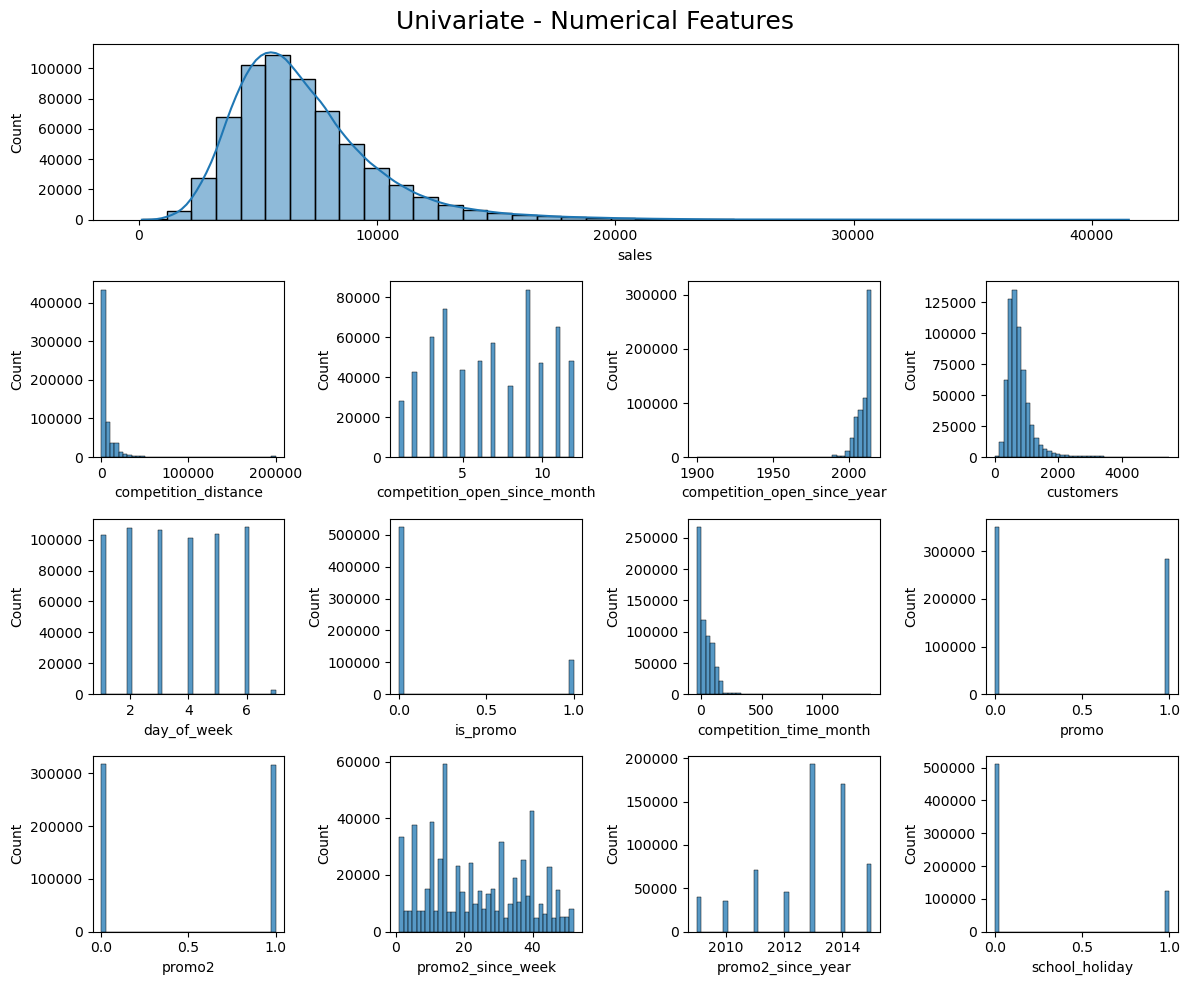

In [62]:
grid = GridSpec(4,4)
plt.figure(figsize=(12,10))
num_cols_to_plot = [
    "competition_distance", "competition_open_since_month", "competition_open_since_year", 
    "customers", "day_of_week", "is_promo", "competition_time_month", "promo", "promo2", "promo2_since_week", 
    "promo2_since_year", "school_holiday"
]

nrows = 6
ncols = 4

ax = plt.subplot(grid[0,:])
plt.suptitle("Univariate - Numerical Features", fontsize=18)
sns.histplot(df_train_with_sales['sales'], bins=40, kde=True, ax=ax);

row = 1
for c, i in enumerate(num_cols_to_plot):
    col = c % 4
    row = row+1 if ((col == 0) and (c != 0)) else row
    
    ax = plt.subplot(grid[row, col])
    if df_train_with_sales[f"{i}"].dtypes == bool:
        sns.histplot(df_train_with_sales[i].astype(int), bins=40, ax=ax);
    else:
        sns.histplot(df_train_with_sales[i], bins=40, ax=ax);

plt.tight_layout()

**WIP:** write here what you inferred from the charts above

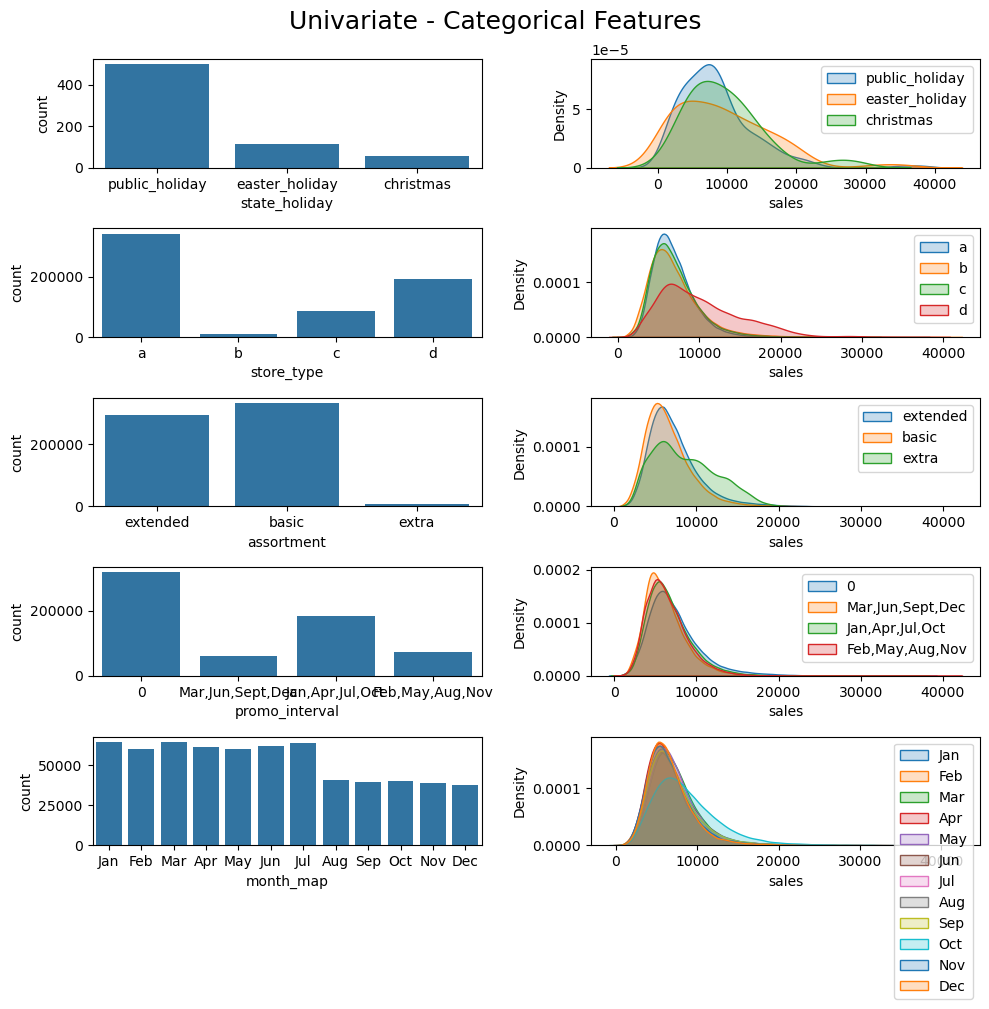

In [63]:
grid = GridSpec(5, 2)

plt.figure(figsize=(10,10))
# state_holiday
plt.subplot(grid[0,0])
plt.suptitle("Univariate - Categorical Features", fontsize=18)
sns.countplot(data=df_train_with_sales[df_train_with_sales['state_holiday']!='regular_day'], x='state_holiday');

plt.subplot(grid[0,1])
for i in df_train_with_sales.loc[df_train_with_sales['state_holiday']!='regular_day','state_holiday'].unique():
    sns.kdeplot(df_train_with_sales.loc[df_train_with_sales['state_holiday']==i, 'sales'], label=i, fill=True);
plt.legend()

# store_type
plt.subplot(grid[1,0])
sns.countplot(data=df_train_with_sales, x='store_type', order=['a','b','c','d']);

plt.subplot(grid[1,1])
for i in df_train_with_sales['store_type'].unique():
    sns.kdeplot(df_train_with_sales.loc[df_train_with_sales['store_type']==i, 'sales'], label=i, fill=True);
plt.legend(labels=['a','b','c','d'])

# assortment
plt.subplot(grid[2,0])
sns.countplot(data=df_train_with_sales, x='assortment');

plt.subplot(grid[2,1])
for i in df_train_with_sales['assortment'].unique():
    sns.kdeplot(df_train_with_sales.loc[df_train_with_sales['assortment']==i, 'sales'], label=i, fill=True);
plt.legend()

# promo_interval
plt.subplot(grid[3,0])
sns.countplot(data=df_train_with_sales, x='promo_interval');

plt.subplot(grid[3,1])
for i in df_train_with_sales['promo_interval'].unique():
    sns.kdeplot(df_train_with_sales.loc[df_train_with_sales['promo_interval']==i, 'sales'], label=i, fill=True);
plt.legend()

# month
plt.subplot(grid[4,0])
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.countplot(data=df_train_with_sales, x='month_map', order=months);

plt.subplot(grid[4,1])
for i in df_train_with_sales['month_map'].unique():
    sns.kdeplot(df_train_with_sales.loc[df_train_with_sales['month_map']==i, 'sales'], label=i, fill=True);
plt.legend(labels=months)

plt.tight_layout()

**WIP:** write here what you inferred from the charts above

## Bivariate Analysis

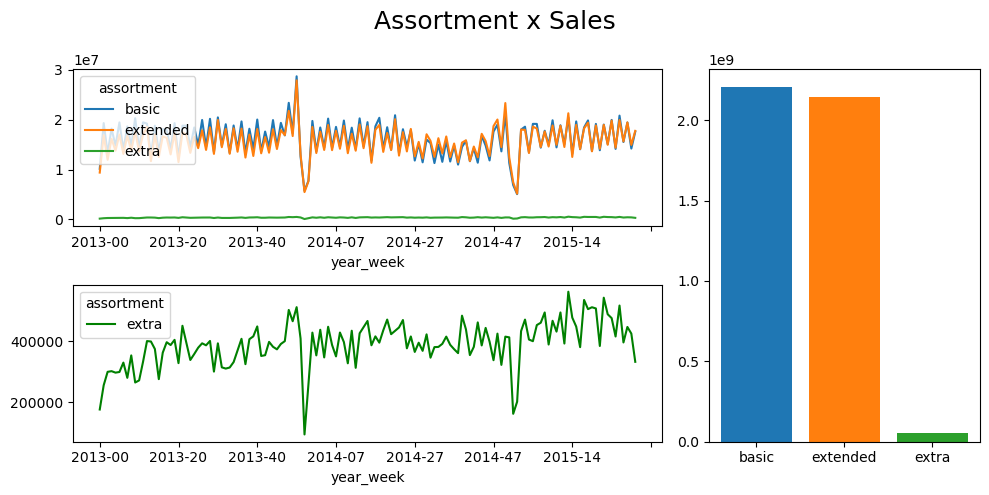

In [64]:
grid = GridSpec(2, 3)

# assortment x sales
plt.figure(figsize=(10,5))
aux = df_train_with_sales[['assortment', 'sales']].groupby('assortment').sum().reset_index()

aux1 = df_train_with_sales[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
ax = plt.subplot(grid[0,:2])
aux1.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax);
plt.legend(loc='upper left', title='assortment');

aux1 = aux1[aux1['assortment'] == 'extra']
ax = plt.subplot(grid[1,:2])
aux1.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax, color='g')

plt.subplot(grid[:,2])
plt.suptitle("Assortment x Sales", fontsize=18)
plt.bar(
    data   = aux,
    x      = 'assortment',
    height = 'sales',
    label  = aux['assortment'].nunique(),
    color  = sns.color_palette("tab10", n_colors=aux['assortment'].nunique())
);

plt.tight_layout()
plt.show();

**WIP:** write here what you inferred from the charts above

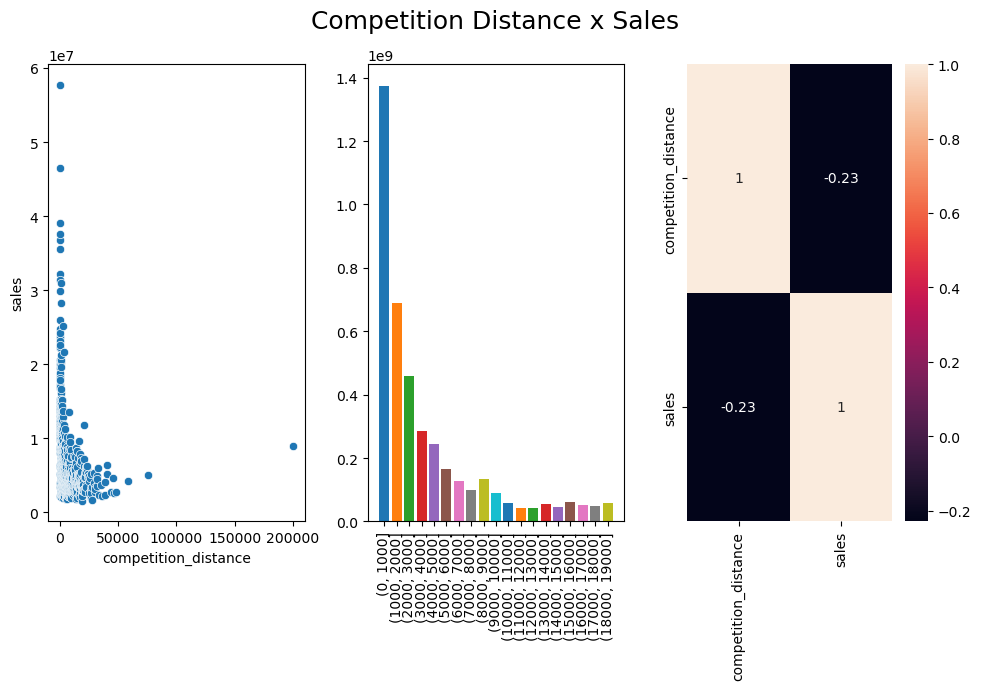

In [65]:
# competition distance x sales
aux = df_train_with_sales[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

grid = GridSpec(1, 3)

plt.figure(figsize=(10,7))
plt.suptitle("Competition Distance x Sales", fontsize=18)
plt.subplot(grid[0,0])
sns.scatterplot(x ='competition_distance', y='sales', data=aux);

plt.subplot(grid[0,1])
bins = list(np.arange(0, 20000, 1000))
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins=bins)
aux2 = aux[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=True).sum().reset_index()
aux2['competition_distance_binned'] = aux2['competition_distance_binned'].astype(str)
plt.bar(
    data   = aux2,
    x      = 'competition_distance_binned', 
    height = 'sales',
    color  = sns.color_palette("tab10", n_colors=aux2['competition_distance_binned'].nunique())
);
plt.xticks(rotation=90);

plt.subplot(grid[0,2])
aux = df_train_with_sales[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
x = sns.heatmap(aux.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show();

**WIP:** write here what you inferred from the charts above

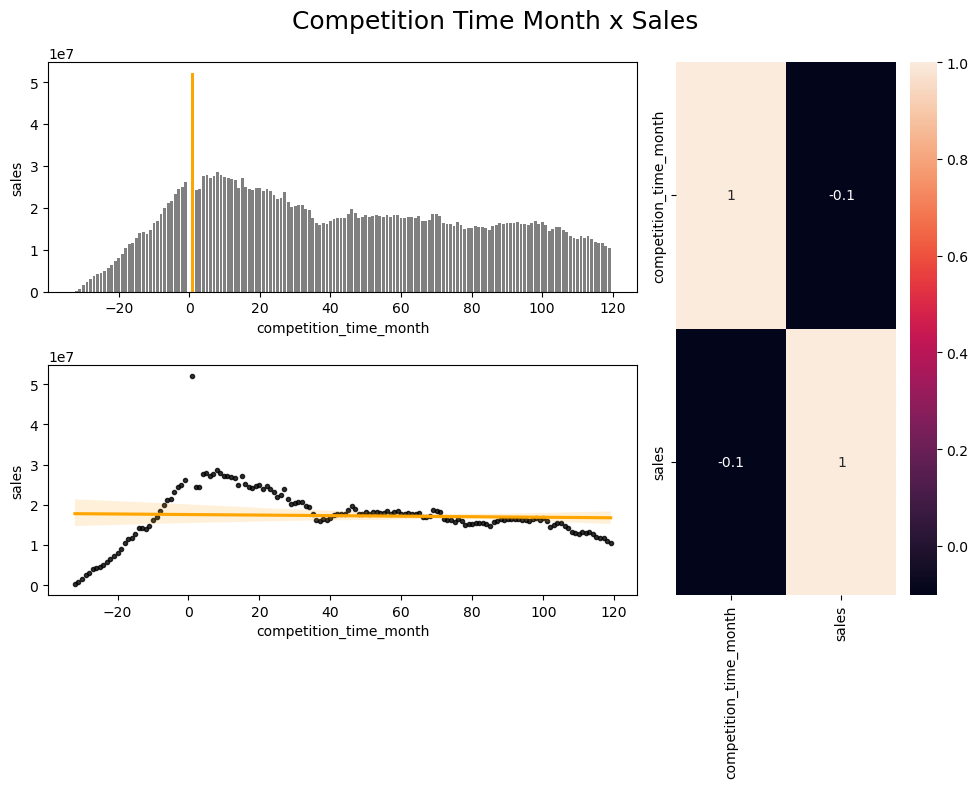

In [66]:
plt.figure(figsize=(10,8))

grid = GridSpec(2, 3)

plt.subplot(grid[0,:2])
plt.suptitle('Competition Time Month x Sales', fontsize=18)
aux1 = df_train_with_sales[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)] # max 10 years
plt.bar(
    data   = aux2,
    x      = 'competition_time_month',
    height = 'sales',
    color  = ['grey' if (x < max(aux2.sales)) else 'orange' for x in aux2.sales]
);
plt.xlabel('competition_time_month')
plt.ylabel('sales')

plt.subplot(grid[1,:2])
sns.regplot(
    data   = aux2,
    x      = 'competition_time_month', 
    y      = 'sales',
    marker = '.',
    scatter_kws={"color": "black"}, 
    line_kws={"color": "orange"}

);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show();

**WIP:** write here what you inferred from the charts above

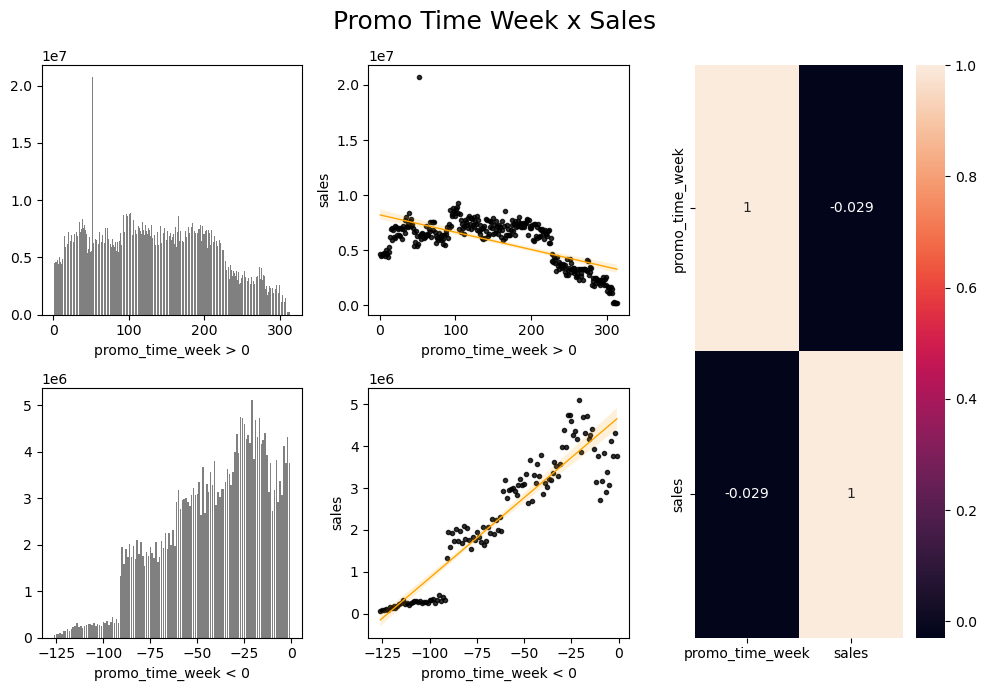

In [67]:
plt.figure(figsize=(10,7))
aux1 = df_train_with_sales[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
plt.suptitle('Promo Time Week x Sales', fontsize=18)
on_going_promos = aux1[aux1['promo_time_week'] > 0] # on going promo (extended: promo2)
plt.bar(
    data   = on_going_promos,
    x      = 'promo_time_week',
    height = 'sales',
    color='grey'
)
plt.xlabel('promo_time_week > 0')

plt.subplot(grid[0,1])
sns.regplot(
    data     = on_going_promos,
    x        = 'promo_time_week',
    y        = 'sales',
    marker   = '.',
    scatter_kws={"color": "black"},
    line_kws = {"color": "orange", "lw":1}
);
plt.xlabel('promo_time_week > 0')

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # future promo (regular: promo)
plt.bar(
    data   = aux3,
    x      = 'promo_time_week',
    height = 'sales',
    color='grey'
)
plt.xlabel('promo_time_week < 0')

plt.subplot(grid[1,1])
sns.regplot(
    data     = aux3,
    x        = 'promo_time_week',
    y        = 'sales',
    marker   = '.',
    scatter_kws={"color": "black"},
    line_kws = {"color": "orange", "lw":1}
);
plt.xlabel('promo_time_week < 0')

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show();

**WIP:** write here what you inferred from the charts above

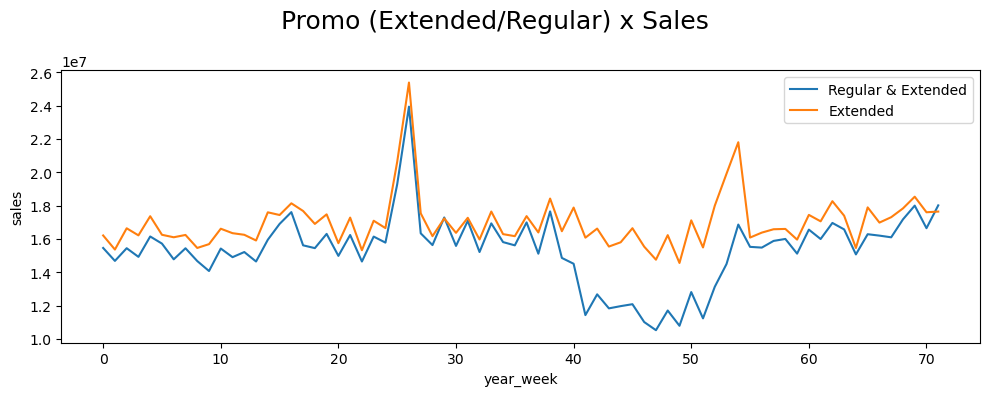

In [68]:
aux1 = df_train_with_sales.loc[
    (df_train_with_sales['promo'] == 1) & (df_train_with_sales['promo2'] == 1),
    ['year_week', 'sales']
].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(10,4))

aux2 = df_train_with_sales.loc[
    (df_train_with_sales['promo'] == 1) & (df_train_with_sales['promo2'] == 0),
    ['year_week', 'sales']
].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Regular & Extended', 'Extended']);
plt.xlabel("year_week")
plt.ylabel("sales")
plt.suptitle("Promo (Extended/Regular) x Sales", fontsize=18)
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

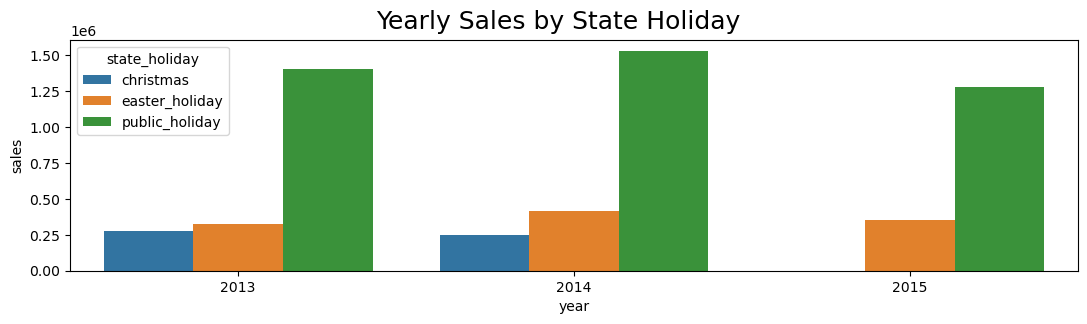

In [69]:
aux = df_train_with_sales[df_train_with_sales['state_holiday'] != 'regular_day']
aux = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.figure(figsize=(13,3))
ax = sns.barplot(x='year', y='sales', hue='state_holiday', data=aux);
plt.suptitle("Yearly Sales by State Holiday", fontsize=18);

**WIP:** write here what you inferred from the charts above

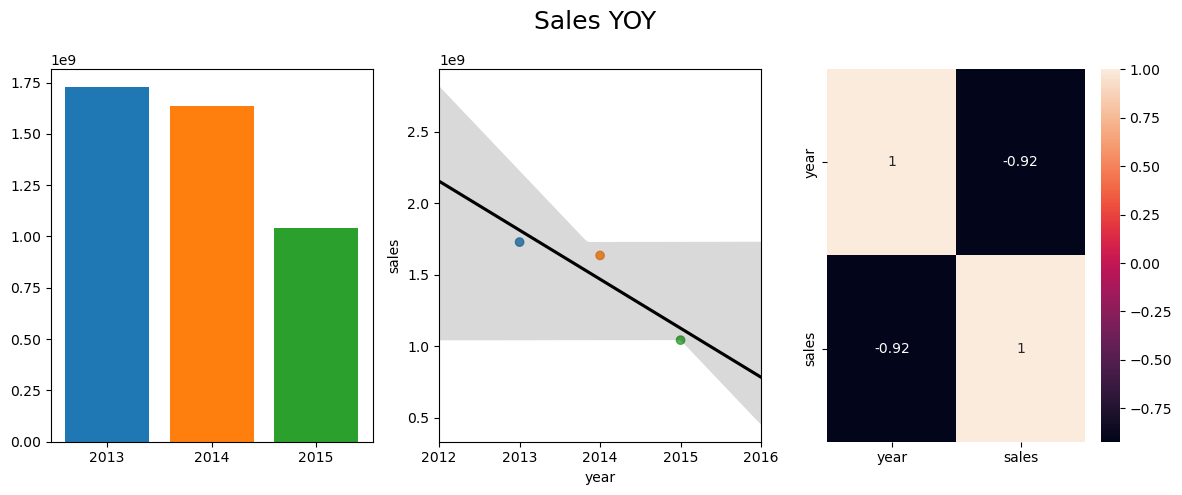

In [70]:
grid = GridSpec(1,3)

plt.figure(figsize=(12,5))
aux = df_train_with_sales[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot(grid[0,0])
plt.bar(
    data = aux,
    x    = 'year',
    height = 'sales',
    color  = sns.color_palette("tab10", n_colors=aux['year'].nunique())
);
plt.xticks(aux['year'].unique())

plt.subplot(grid[0,1])
plt.xlim(2012,2016)
sns.regplot(
    data = aux,
    x    = 'year',
    y    = 'sales',
    scatter_kws = {'color': sns.color_palette("tab10", n_colors=aux['year'].nunique())},
    line_kws    = {'color':'black'},
    truncate = False
);

plt.subplot(grid[0,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

plt.suptitle('Sales YOY', fontsize=18)
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

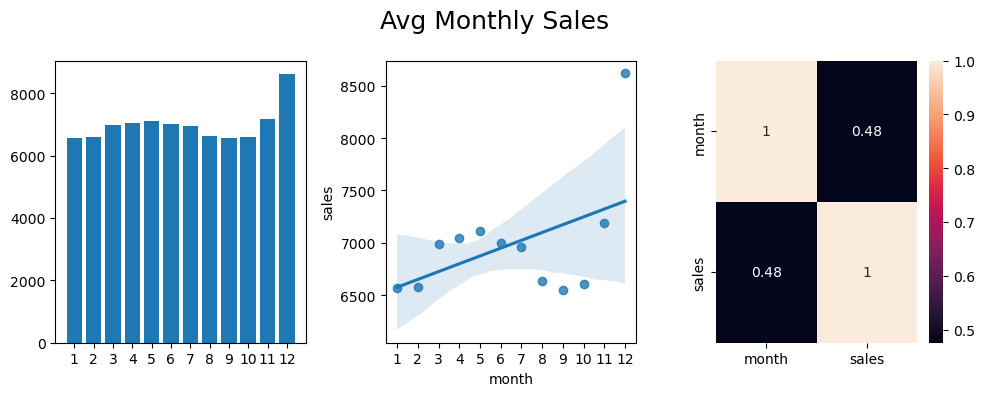

In [71]:
grid = GridSpec(1,3)
aux1 = df_train_with_sales[['month', 'sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(10,4))

plt.subplot(grid[0,0])
plt.bar(
    data = aux1,
    x = 'month',
    height = 'sales'
);
plt.xticks(range(1,13))

plt.subplot(grid[0,1])
sns.regplot(x='month', y='sales', data=aux1);
plt.xticks(range(1,13))

plt.subplot(grid[0,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.suptitle('Avg Monthly Sales', fontsize=18)
plt.tight_layout()

In [94]:
len(sns.color_palette("husl", n_colors=aux1['day'].nunique()))

31

**WIP:** write here what you inferred from the charts above

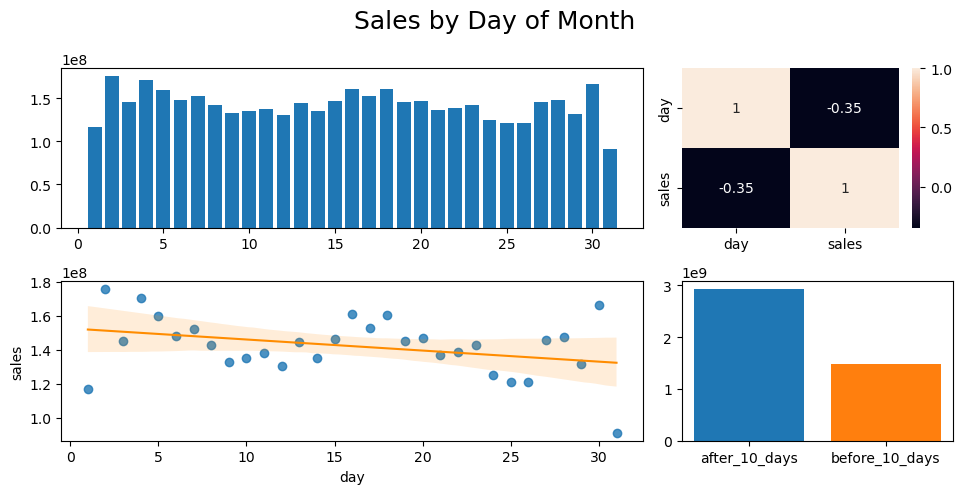

In [124]:
grid = GridSpec(2,3)
aux1 = df_train_with_sales[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.figure(figsize=(10,5))
plt.subplot(grid[0,:2])
plt.bar(
    data   = aux1,
    x      = 'day',
    height = 'sales',
    # color  = sns.color_palette("husl", n_colors=aux1['day'].nunique())
);

plt.subplot(grid[1,:2])
sns.regplot( 
    data        = aux1,
    x           = 'day',
    y           = 'sales',
    line_kws    = {'lw':1.5, 'color':'darkorange'}
);

plt.subplot(grid[0,2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(grid[1,2])
plt.bar(
    data   = aux2,
    x      = 'before_after', 
    height = 'sales',
    color  = sns.color_palette("tab10", n_colors=aux2['before_after'].nunique())
);

plt.suptitle('Sales by Day of Month', fontsize=18)
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

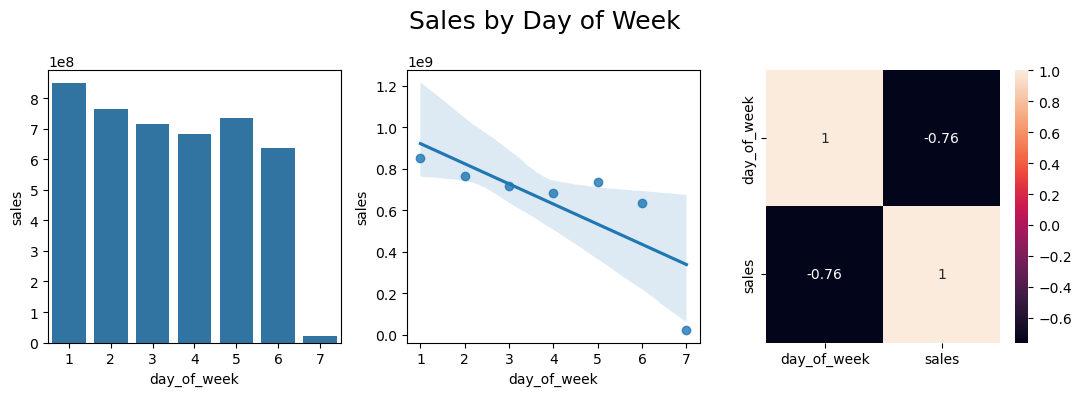

In [133]:
grid = GridSpec(1, 3)

plt.figure(figsize=(11,4))

aux1 = df_train_with_sales[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(grid[0,0])
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[0,1])
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(grid[0,2])
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

plt.suptitle('Sales by Day of Week', fontsize=18)
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

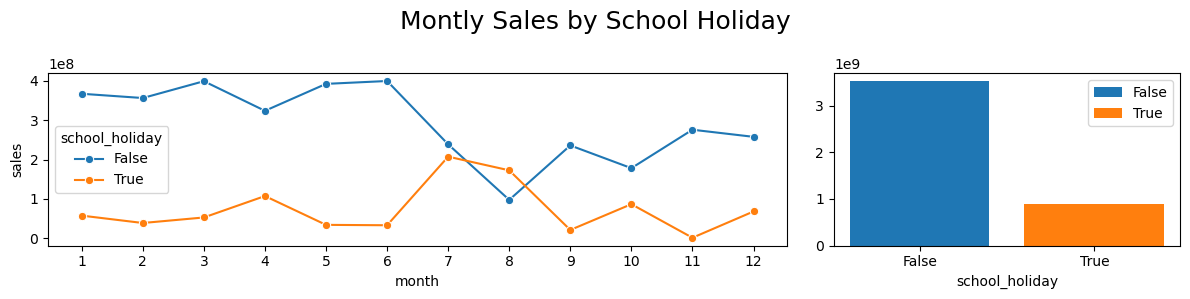

In [194]:
grid = GridSpec(1,3)

aux1 = df_train_with_sales[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux1['school_holiday'] = aux1['school_holiday'].astype(bool)

plt.figure(figsize=(12,3))
plt.subplot(grid[0,2])
ax = plt.bar(
    data   = aux1,
    x      = 'school_holiday', 
    height = 'sales',
    color  = sns.color_palette("tab10", n_colors=aux1['school_holiday'].nunique()),
    label  = ['False', 'True']
    
);
plt.xlabel('school_holiday')
plt.xticks(labels=['False','True'], ticks=[0,1])
plt.legend()

aux2 = df_train_with_sales[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
aux2['school_holiday'] = aux2['school_holiday'].astype(bool)

plt.subplot(grid[0,:2])
sns.lineplot(
    x='month',
    y='sales',
    hue='school_holiday',
    marker='o',
    data=aux2
);
plt.xticks(range(1,13));

plt.suptitle('Montly Sales by School Holiday', fontsize=18)
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

## Multivariate Analysis

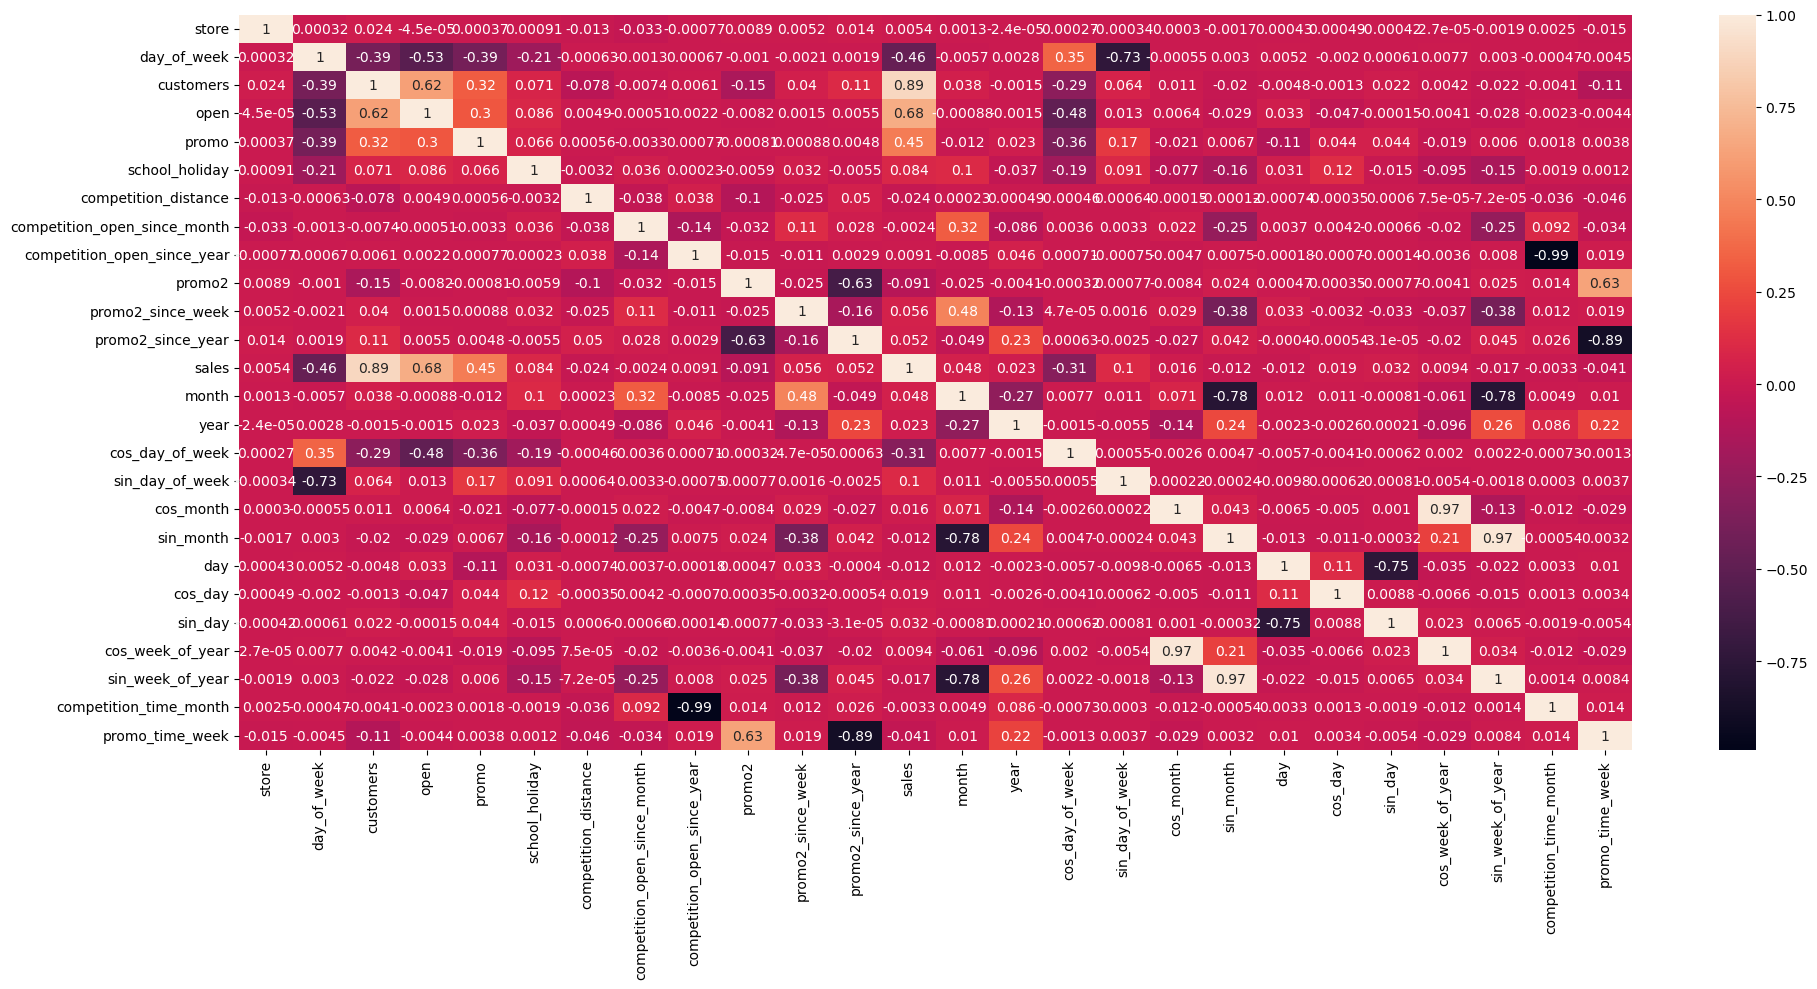

In [203]:
plt.figure(figsize=(20,10))
sns.heatmap(num_features.corr(method='pearson'), annot=True);
plt.tight_layout()

**WIP:** write here what you inferred from the charts above

# Pending

- [x] Why are `competition_time_month` and `promo_time_week` showing negative values?
    - [x] Negative values mean the competition started AFTER the sale of that row. Sometimes we know a store will open in a certain day in the future, specially when it's a internal information of the company.  
- [x] Use `import pygwalker as pyg` for EDA
    - [x] It's too slow for big datasets
- [x] Write charts for:
    - [x] Univariate Analysis
    - [x] Bivariate Analysis
    - [x] Multivariate Analysis
- [ ] Write insights from the charts in:
    - [ ] Univariate Analysis
    - [ ] Bivariate Analysis
    - [ ] Multivariate Analysis